let us start by importing the required functions

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
# import statsemodels.api as sm
import SALib
import seaborn as sns
import mpl_toolkits.axisartist as AA
import mpld3
import scipy as sp
import copy
import matplotlib.ticker as ticker

from ema_workbench import (Model, RealParameter, IntegerParameter, Policy, CategoricalParameter, Constant, TimeSeriesOutcome, ScalarOutcome, perform_experiments, ema_logging, save_results, load_results)
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS, SequentialEvaluator
from ema_workbench.connectors.pysd_connector import PysdModel 
# from ema_workbench.connectors import vensimDLLwrapper
# from ema_workbench.connectors.vensim import VensimModel
from ema_workbench.em_framework.samplers import sample_levers, sample_uncertainties
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.util import load_results
from ema_workbench.util import ema_logging

# from ema_workbench.analysis import prim
from ema_workbench.analysis.plotting import lines, multiple_densities, kde_over_time
from ema_workbench.analysis.plotting_util import KDE
from ema_workbench.analysis.plotting_util import determine_time_dimension
from ema_workbench.analysis.pairs_plotting import pairs_scatter

from SALib.sample import saltelli
from SALib.analyze import sobol, morris
from SALib.test_functions import Ishigami

from mpl_toolkits.axes_grid1 import host_subplot

from scipy.stats import linregress

ema_logging.log_to_stderr(ema_logging.INFO)

C:\Users\Gurvinder\Anaconda3\lib\site-packages\ema_workbench\em_framework\optimization.py:23: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)
C:\Users\Gurvinder\Anaconda3\lib\site-packages\ema_workbench\connectors\__init__.py:8: ImportWarning: vensim connector not available
  warnings.warn("vensim connector not available", ImportWarning)
C:\Users\Gurvinder\Anaconda3\lib\site-packages\ema_workbench\connectors\__init__.py:18: ImportWarning: netlogo connector not available
  warnings.warn("netlogo connector not available", ImportWarning)
C:\Users\Gurvinder\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


<Logger EMA (DEBUG)>

# Comparing Robust Policy performances

In [2]:
vensimModel = VensimModel("BaseCase", model_file="PolicyforObjectives_Step6_BaseCase.vpm" )

In [3]:
vensimModel.uncertainties = [

            RealParameter("Average Fertility Rate", 0.01, 0.025),
            RealParameter("Average Mortality Rate", 0.00126, 0.00154),
            IntegerParameter("BASE Average Household size", 2, 7),
#             RealParameter("Fraction of people selling houses when leaving city", 0.1, 0.4),     
            RealParameter("average Immigration percent", 0.01, 0.06),
            RealParameter("Housing Area Per person", 0.000004, 0.000006),
            RealParameter("Floor Area Ratio", 2, 7),
            RealParameter("Average Residential approval period", 0.5, 2),
            RealParameter("Base Green Area commisioned per year", 0.02, 0.06),
            RealParameter("average green area construction period", 0.5, 2),
            RealParameter("Base Economic area Conversion rate", 0.01, 0.06),
            RealParameter("Base Slum reconversion rate", 0.01, 0.06),
            RealParameter("Fraction of people selling houses when leaving city", 0.1, 0.5),
            RealParameter("house construction time", 0.5, 2),
            IntegerParameter("time delay effect uncertainty of spending capacity on housing price", 1, 4),
            RealParameter("Slum dwelling area per person", 0.000004, 0.000006),
            RealParameter("Base residential conversion rate", 0.01, 0.05),
            RealParameter("average Emmigration percent", 0.008, 0.05),
            RealParameter("Relocation Rate", 0.001, 0.02), #for relocation of population on streets
            RealParameter("Average Commercial Approval Period", 0.5, 2),
            RealParameter("Base Green Area Reconversion rate", 0.001, 0.03),
            RealParameter("Average Slum Construction period", 0.1, 0.5),
            RealParameter("Average slum Demolition Period", 0.5, 2),
            RealParameter("uncertainty of average percent of inflation effect", 0.01, 0.08),
            RealParameter("average payment to income ratio for housing", 0.2, 0.5),
            RealParameter("Base Non Economic Reconv rate", 0.01 ,0.05),
            RealParameter("Ratio of Renting to Buying",0.2, 1),
            RealParameter("margin of empty housing",0.1,0.5)
]

vensimModel.outcomes = [
    TimeSeriesOutcome('Housing Affordability Rating'),
    TimeSeriesOutcome('People with No Settlements'),
    TimeSeriesOutcome('Illegal Slum Population'),
    TimeSeriesOutcome('Urban Non Residential Area'),
    TimeSeriesOutcome('Urban Residential Land'),
    TimeSeriesOutcome('Slum Area'),
    TimeSeriesOutcome('Green Area')
    
]

policies = [Policy('no_policy',
                   model_file="PolicyforObjectives_Step6_BaseCase.vpm"),
            Policy('Stat_pol',
                   model_file="PolicyforObjectives_Step6_Full Policies_Static_Solution11.vpm"),
            Policy('Dyn_pol_Eco',
                   model_file="PolicyforObjectives_Step6_Full Policies_EconomicFocus_solution11.vpm"),
            Policy('Dyn_pol_afford',
                   model_file="PolicyforObjectives_Step6_Full Policies_AffordabilityFocus_Solution2.vpm"),
            Policy('adapt_pol_Eco',
                   model_file="PolicyforObjectives_Step6_Full Policies_adaptive_EconomicFocus_Solution28.vpm"),
             Policy('adapt_pol_afford',
                    model_file="PolicyforObjectives_Step6_Full Policies_adaptive_AffordabilityFocus_Solution35.vpm")
           ]

In [4]:
results = perform_experiments(vensimModel, scenarios=500, policies=policies, uncertainty_sampling=LHS)

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


In [5]:
results_name = './Step6Policy_Compare_LHS_500.tar.gz'
save_results(results, results_name)

[MainProcess/INFO] results saved successfully to E:\Study\Delft\Papers\V2\Step6Policy_Compare_LHS_500.tar.gz


In [4]:
import matplotlib.pyplot as plt
# from ema_workbench.analysis.plotting import lines 
# from ema_workbench.analysis.plotting_util import KDE
import ema_workbench.analysis.pairs_plotting as pairs
import ema_workbench.analysis.plotting as emaplt

In [5]:


# outputs = list(results[1].keys())[1:] 

# for x in outputs:
#     fig = emaplt.lines(results, outcomes_to_show=[x], group_by ='policy', density=u'kde')
# plt.rcParams["fig.figsize"] = (30,60)
# plt.show()
experiments, outcomes = results

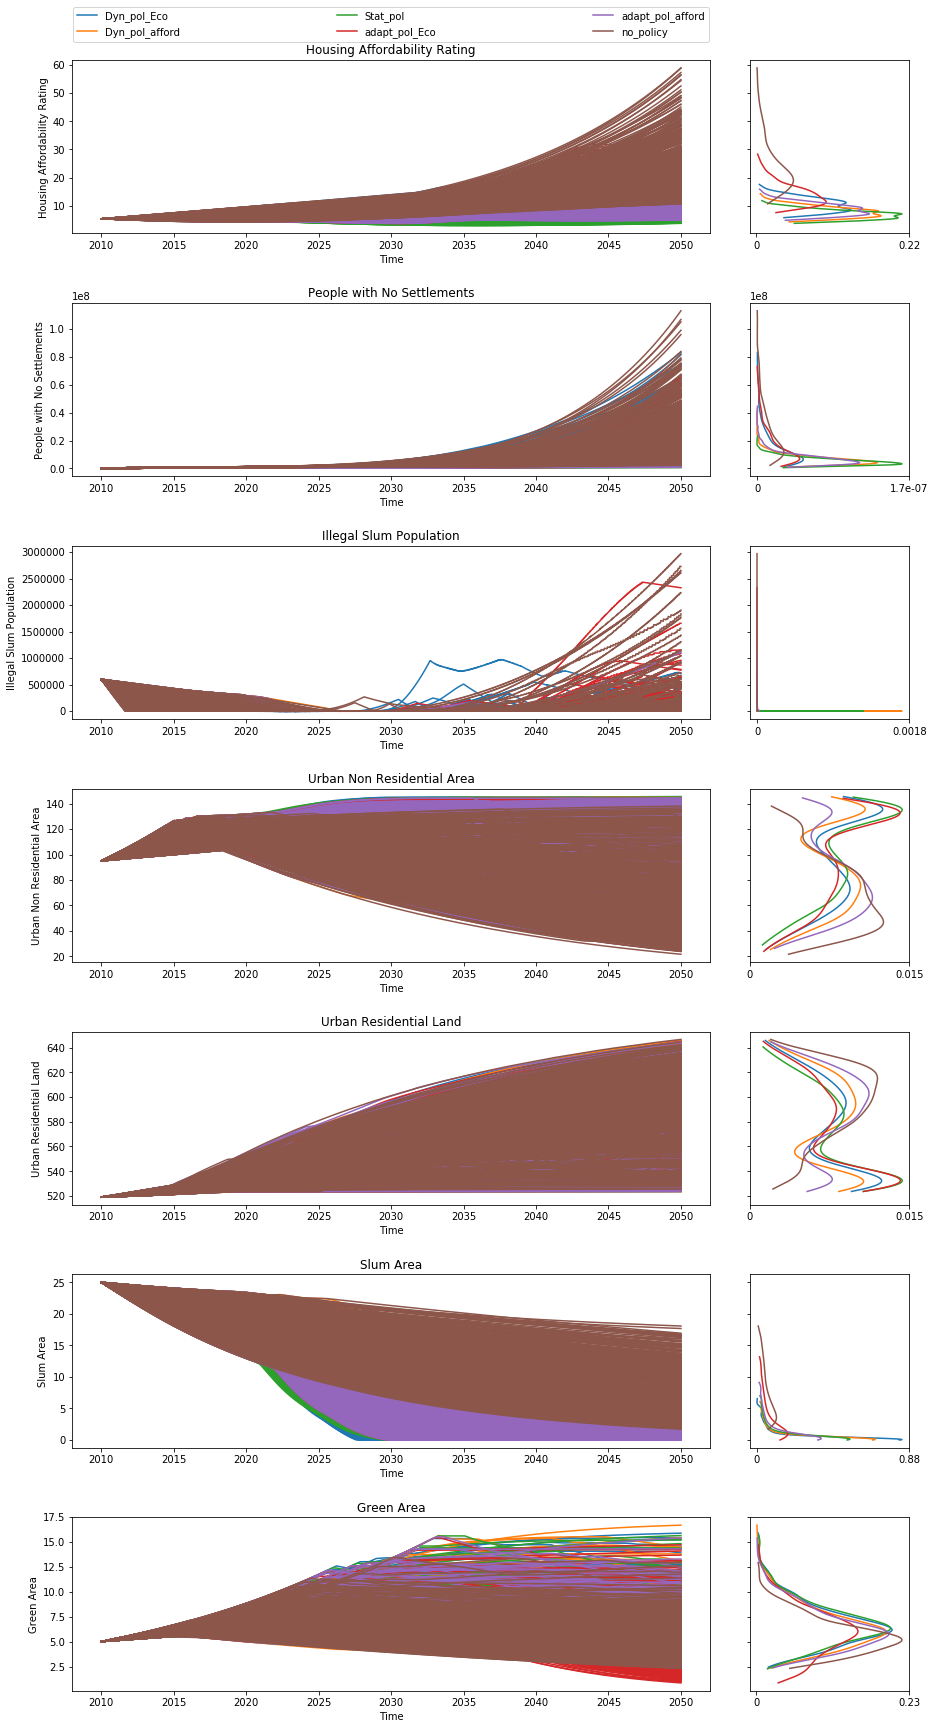

In [20]:
figure = emaplt.lines(results, group_by ='policy', density=u'kde') #show lines, and end state density
# plt.rcParams["figure.figsize"] = (15,30)
plt.show()

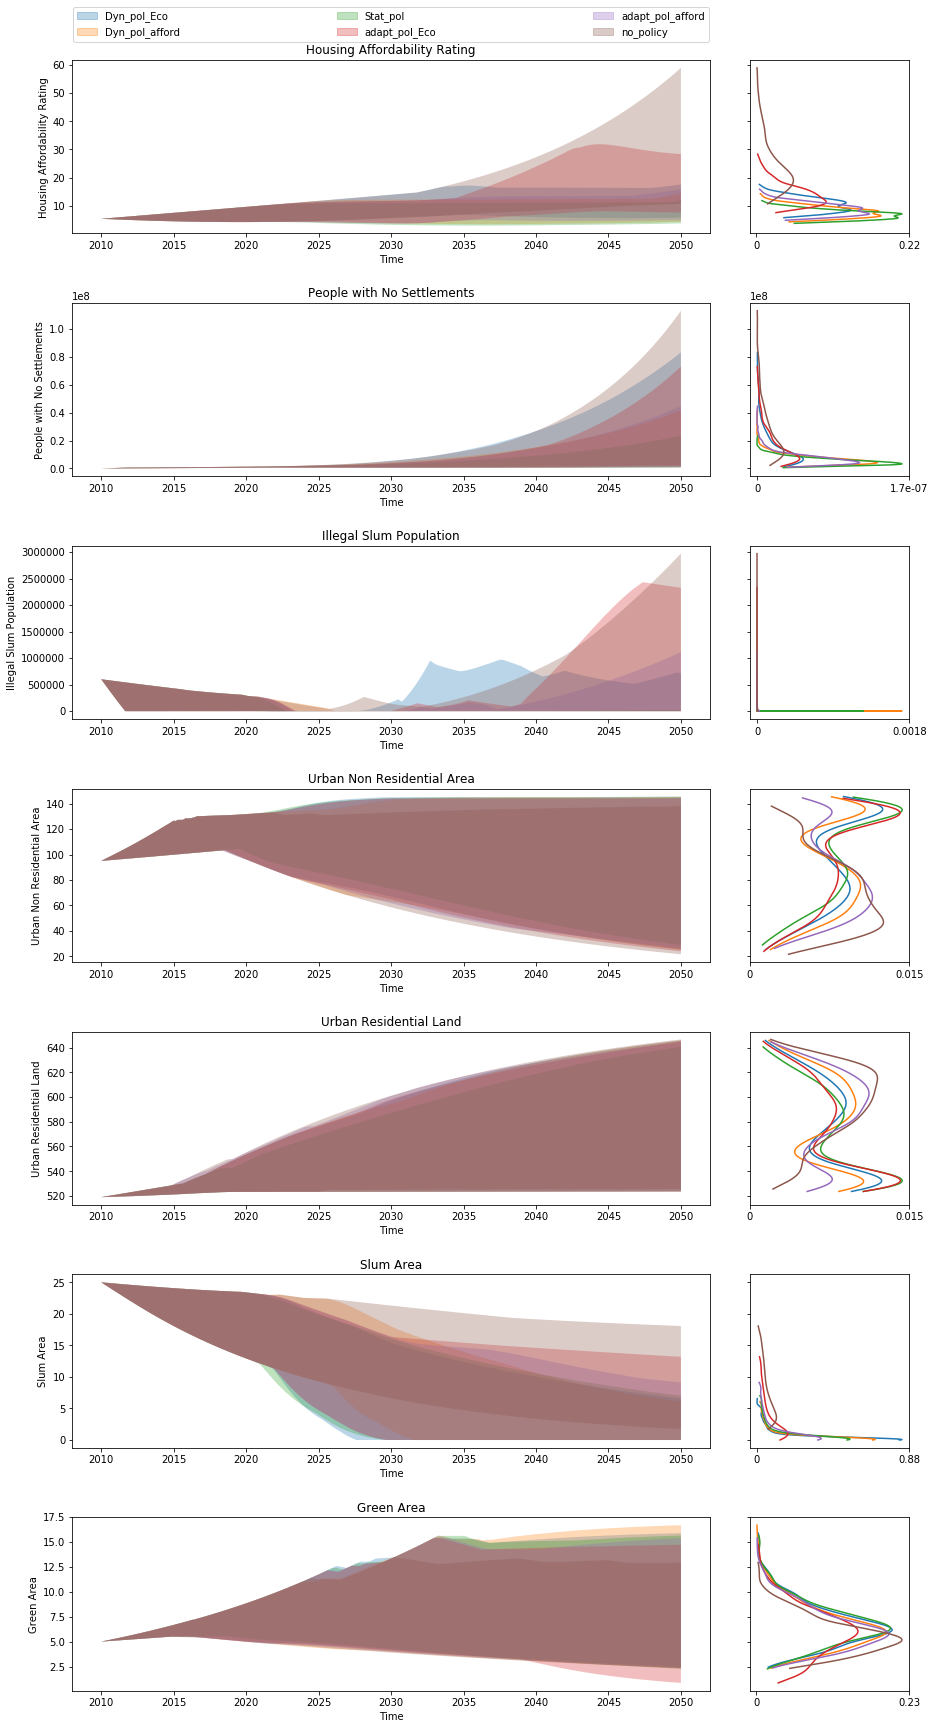

In [22]:
fig = emaplt.envelopes(results, group_by ='policy', density=u'kde', fill= True)
plt.show()

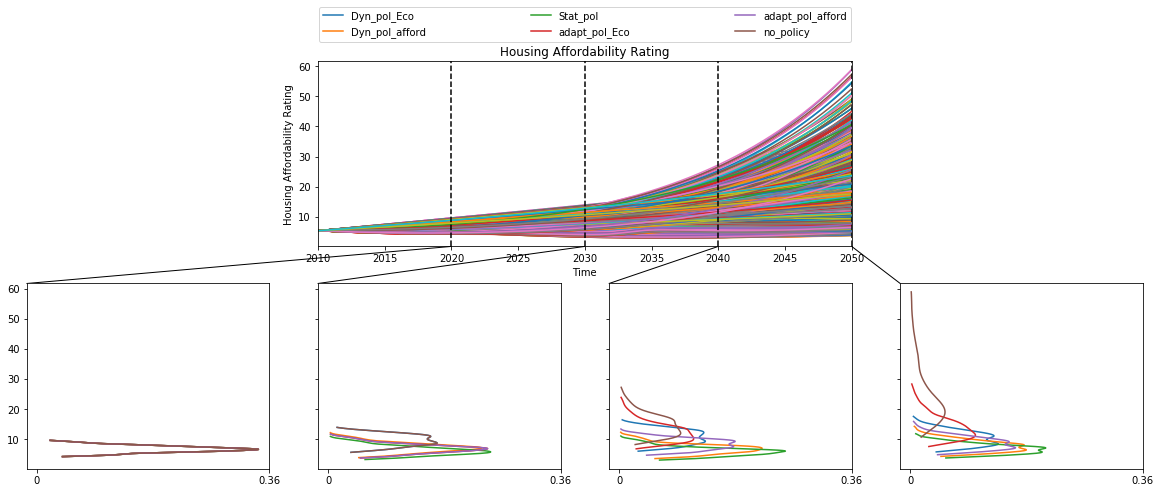

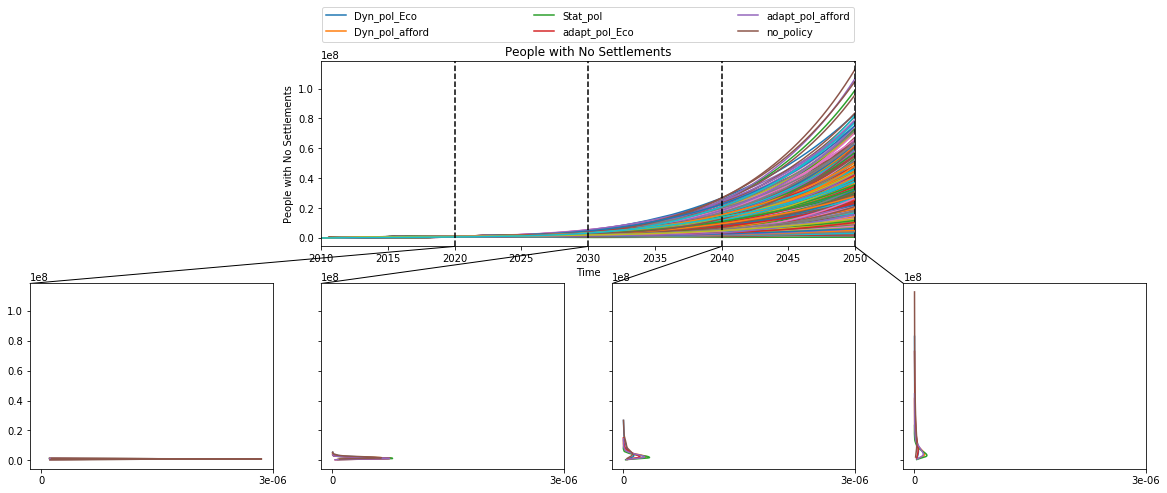

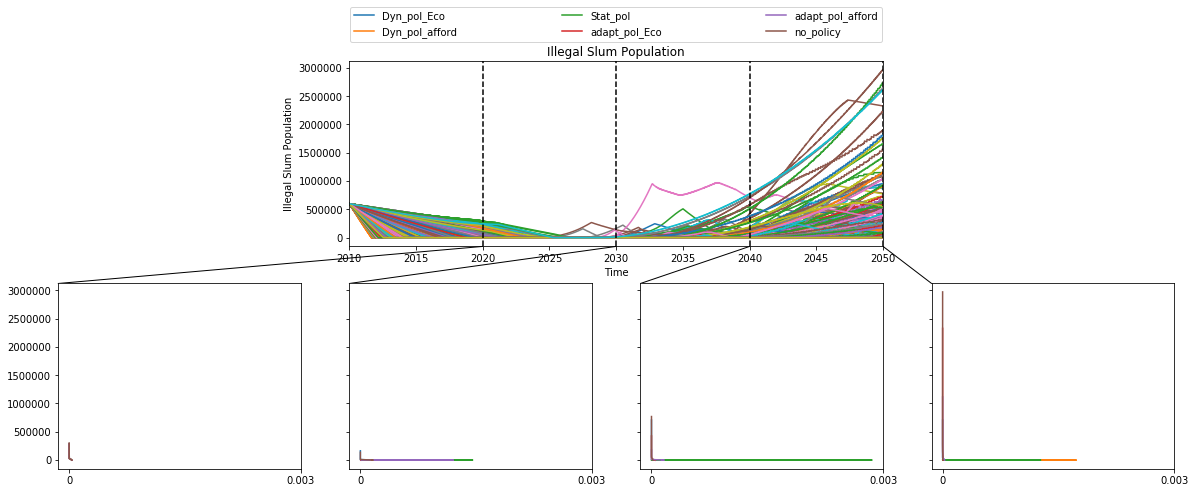

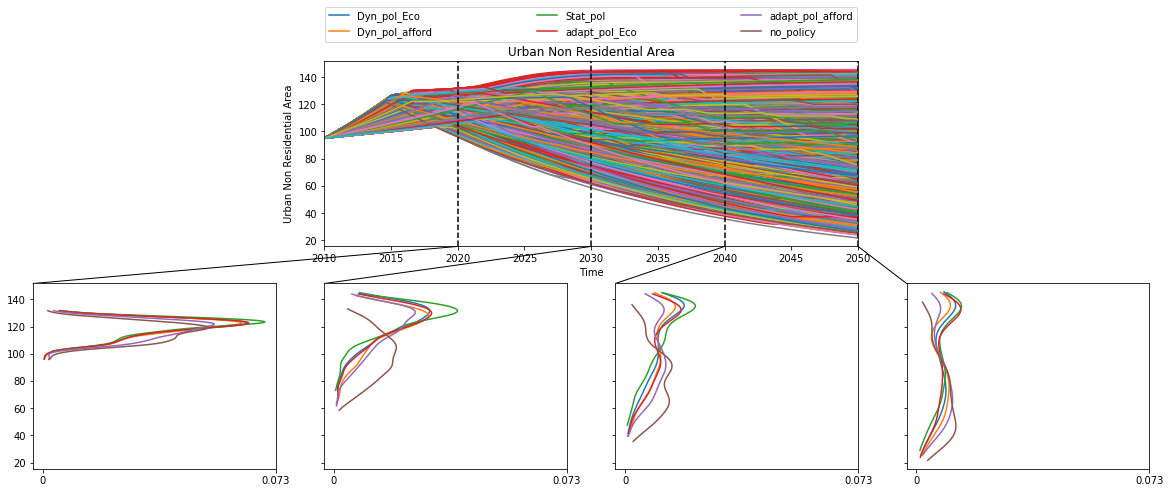

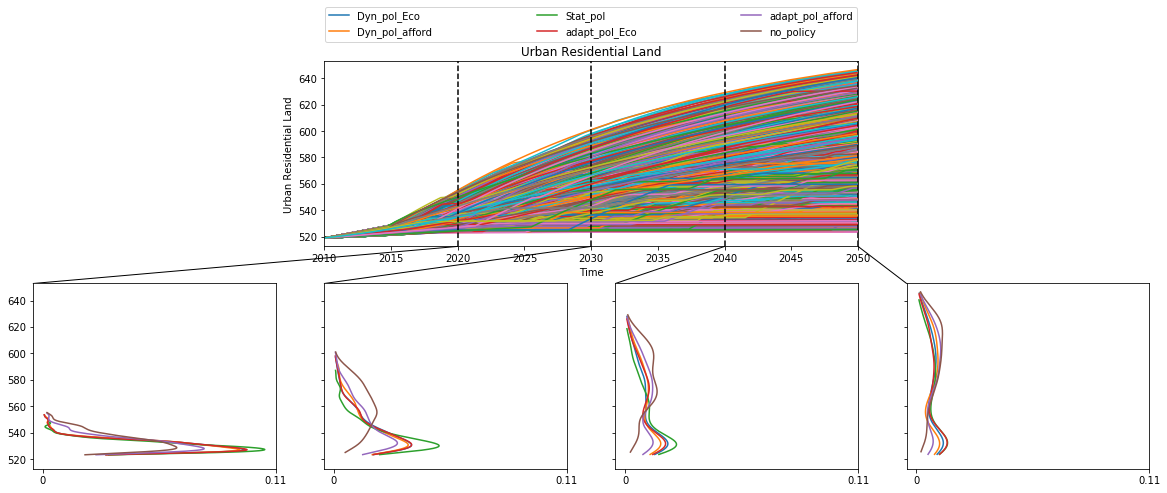

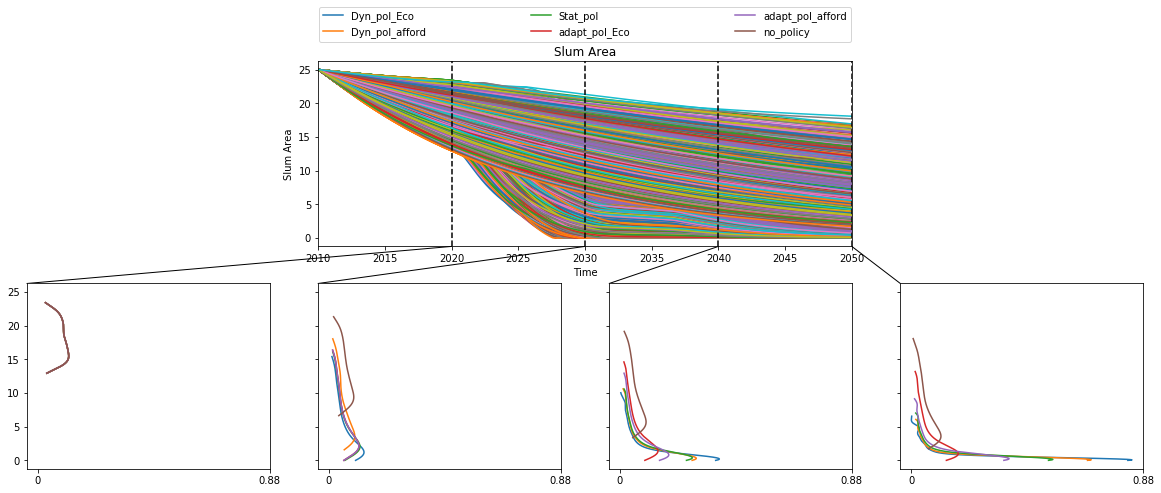

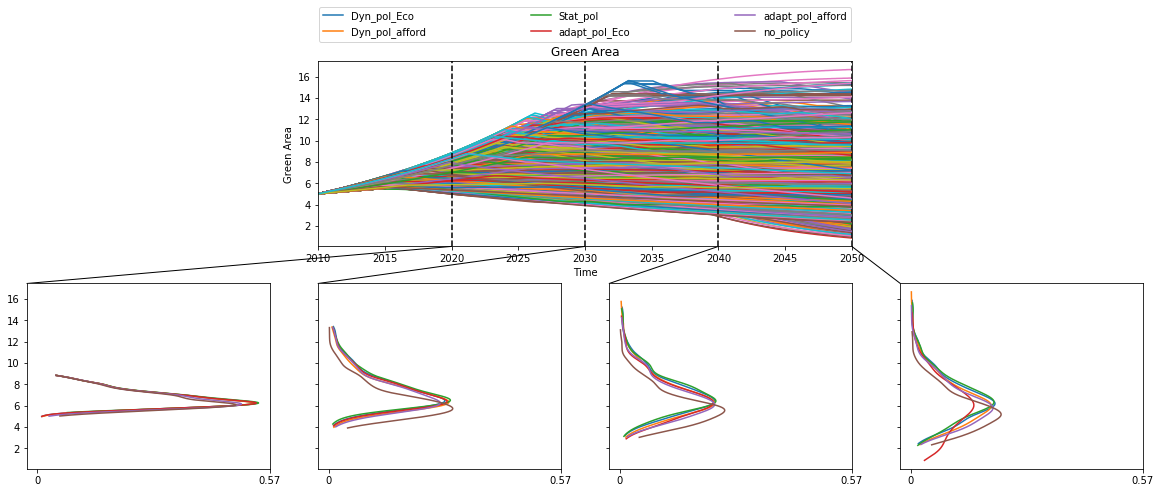

In [18]:
fig = emaplt.multiple_densities(results, points_in_time=[2020, 2030, 2040, 2050], 
                                outcomes_to_show=['Housing Affordability Rating', 'People with No Settlements', 'Illegal Slum Population', 'Urban Non Residential Area', 'Urban Residential Land', 'Slum Area', 'Green Area'], 
                                group_by ='policy', density=u'kde', plot_type = 'lines')
plt.show()

In [15]:
plt.rcParams["figure.figsize"] = (20,7.5)

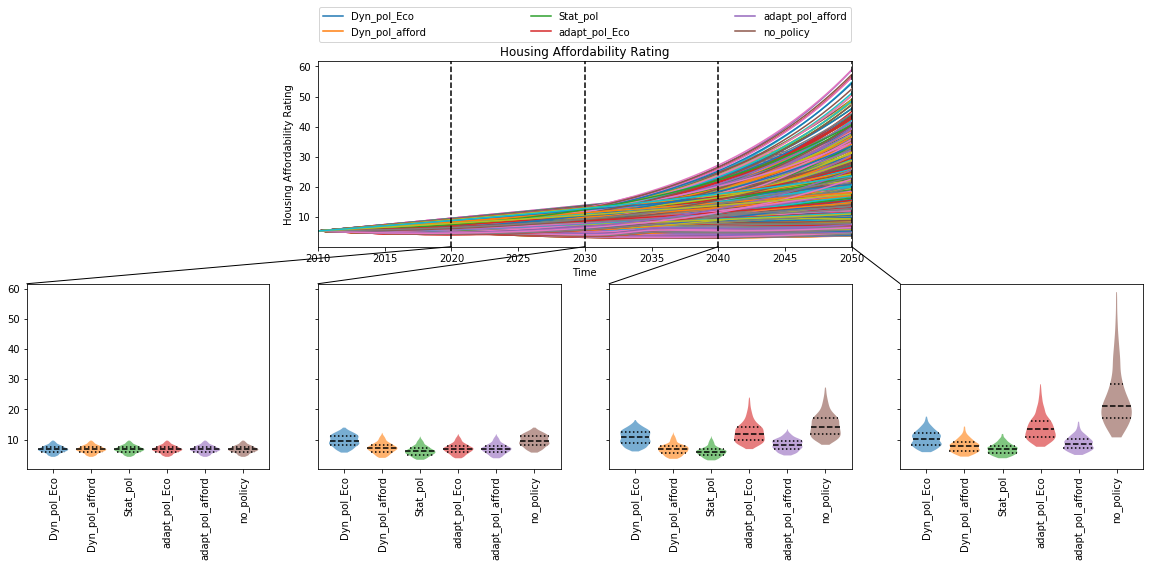

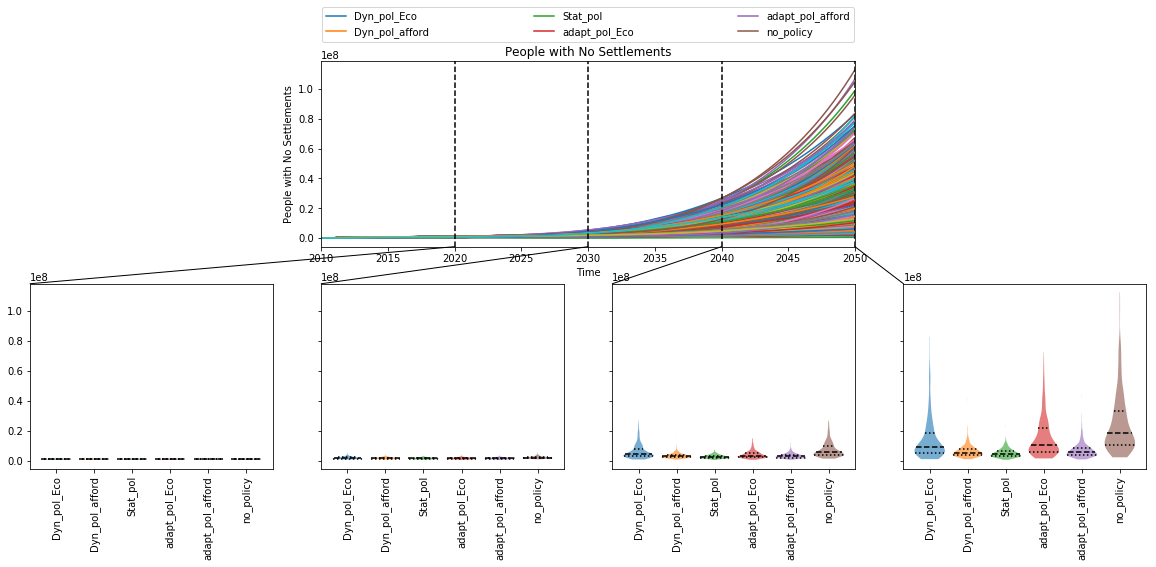

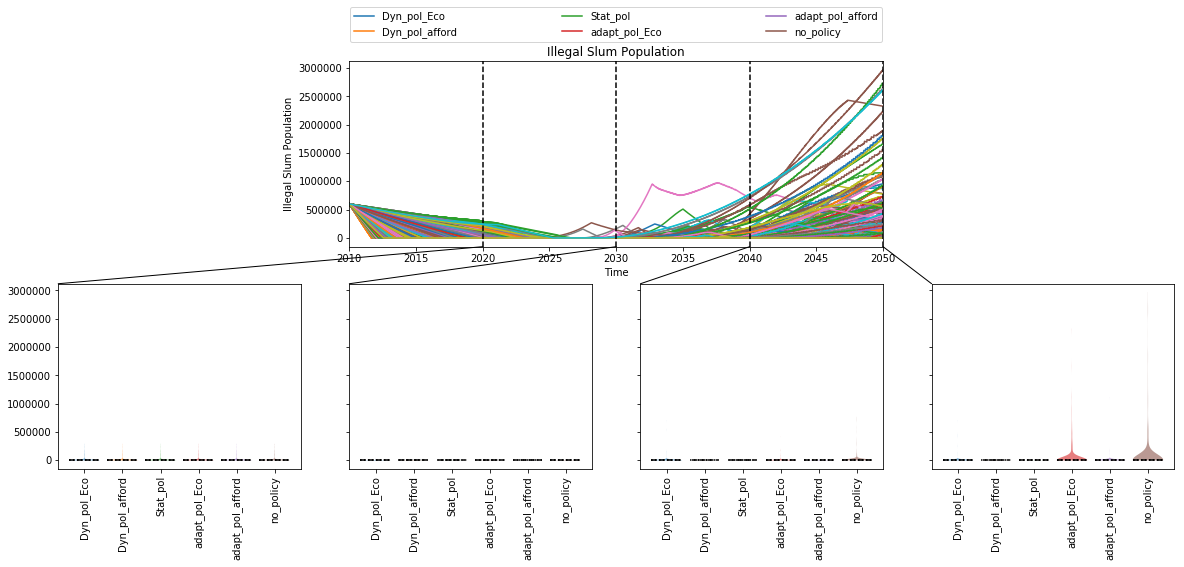

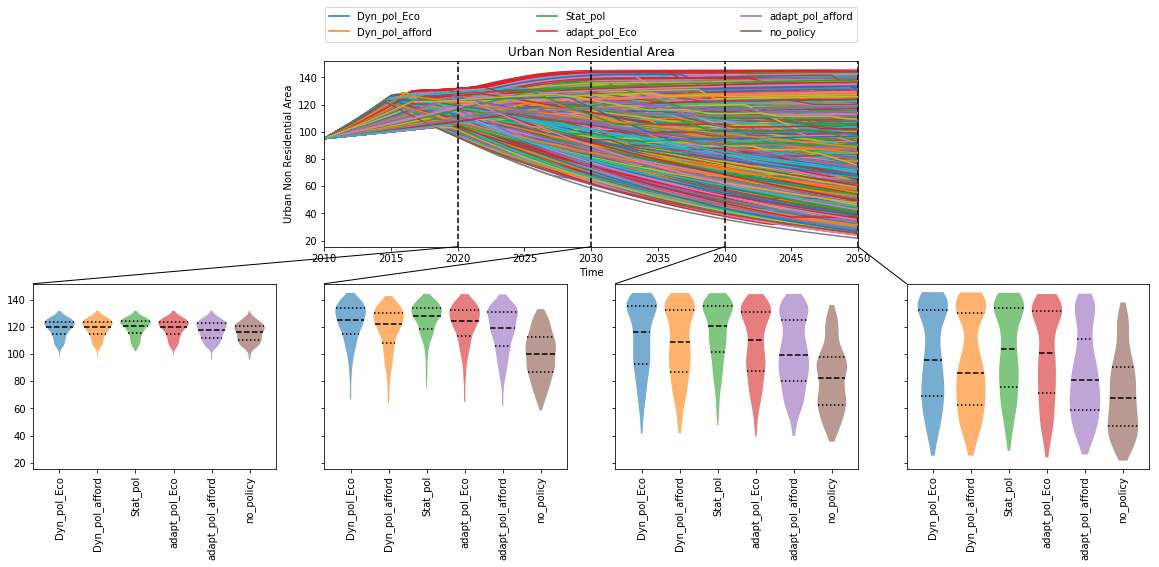

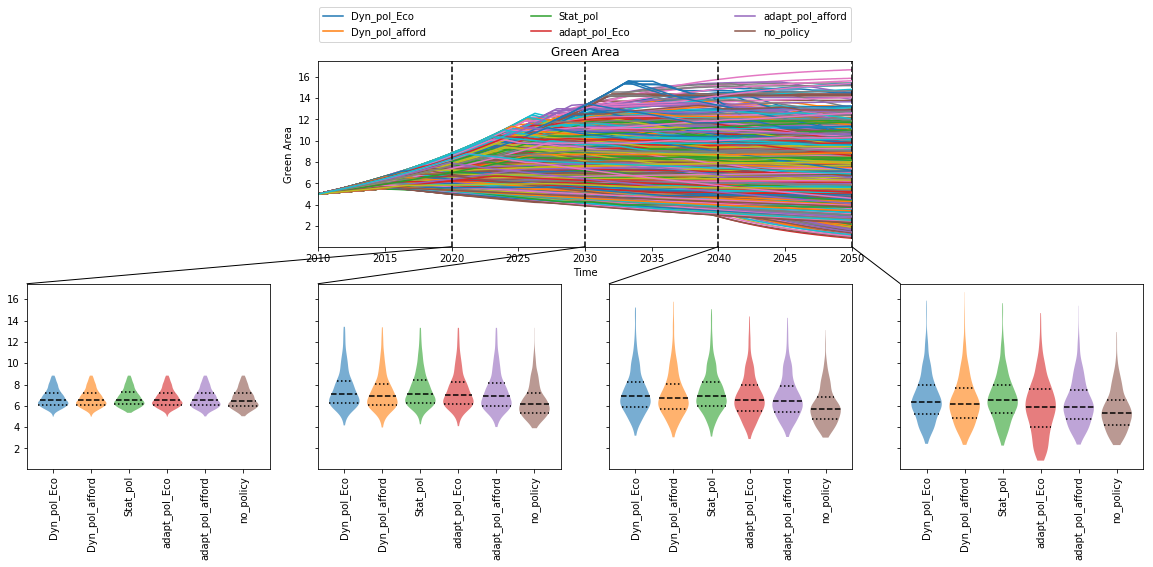

In [16]:
fig = emaplt.multiple_densities(results, points_in_time=[2020, 2030, 2040, 2050], 
                                outcomes_to_show=['Housing Affordability Rating', 'People with No Settlements', 'Illegal Slum Population', 'Urban Non Residential Area', 'Green Area'], 
                                group_by ='policy', density=u'violin', plot_type = 'lines')
# plt.rcParams["figure.figsize"] = (5,15)
plt.show()

In [3]:
results = load_results('./Step6Policy_Compare_LHS_500.tar.gz')

[MainProcess/INFO] results loaded succesfully from E:\Study\Delft\Papers\V2\Step6Policy_Compare_LHS_500.tar.gz


In [3]:
experiments, outcomes = results2

In [4]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyHAfford(data):
    ooi = 'Housing Affordability Rating'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>13] = 1
    return classes


prim_obj = prim.setup_prim(results2, classifyHAfford, threshold=0.8)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 1500 points remaining, containing 321 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.05466666666666667, coverage: 0.2554517133956386, density: 1.0 restricted_dimensions: 12


In [5]:
box_1.show_tradeoff()
mpld3.display()

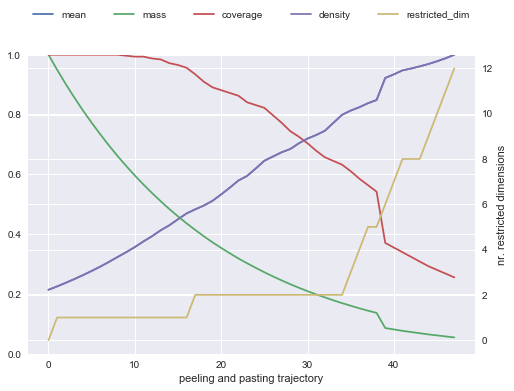

In [6]:
box_1.show_ppt()
plt.show()

coverage     0.58567
density     0.824561
mass           0.152
mean        0.824561
res dim            4
Name: 36, dtype: object

                                               box 36                        
                                                  min       max     qp values
average payment to income ratio for housing  0.447857  0.499965  1.468703e-83
Average Residential approval period          0.583643  1.999789  3.613018e-01
Relocation Rate                              0.001001  0.019314  4.344908e-01
average Immigration percent                  0.010026  0.057656  5.468904e-01



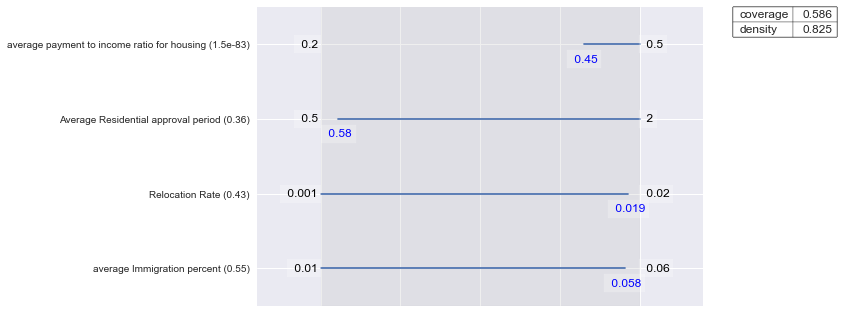

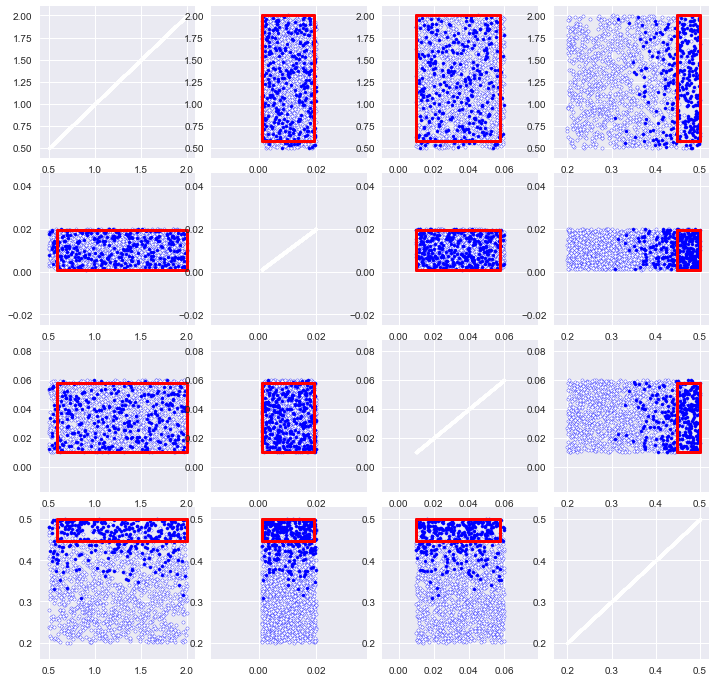

In [7]:
valuebox = 36
box_1.inspect(valuebox)
box_1.select(valuebox)

top_box = valuebox
box_1.inspect(top_box, style='graph')

fig = box_1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [8]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyNoSettle(data):
    ooi = 'People with No Settlements'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>2000000] = 1
    return classes


prim_obj = prim.setup_prim(results2, classifyNoSettle, threshold=0.8)
box_2 = prim_obj.find_box()

[MainProcess/INFO] 1500 points remaining, containing 1351 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.51, coverage: 0.5662472242783123, density: 1.0 restricted_dimensions: 3


In [9]:
box_2.show_tradeoff()
mpld3.display()

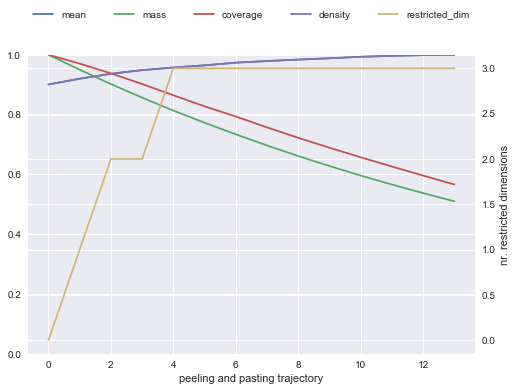

In [10]:
box_2.show_ppt()
plt.show()

coverage    0.864545
density     0.957377
mass        0.813333
mean        0.957377
res dim            3
Name: 4, dtype: object

                                                box 4                    
                                                  min       max qp values
average Immigration percent                  0.014936  0.059989  0.000011
average payment to income ratio for housing  0.216000  0.499965  0.011905
average Emmigration percent                  0.009961  0.049995  0.091080



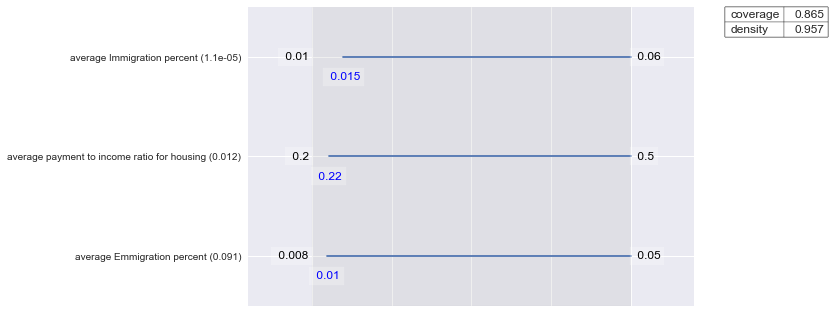

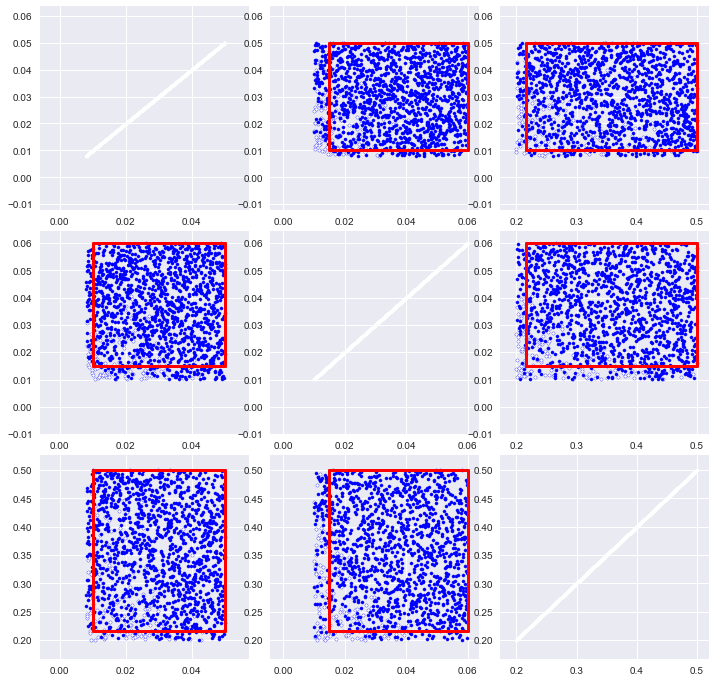

In [11]:
valuebox = 4
box_2.inspect(valuebox)
box_2.select(valuebox)

top_box = valuebox
box_2.inspect(top_box, style='graph')

fig = box_2.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

coverage    0.902295
density     0.948638
mass        0.856667
mean        0.948638
res dim            2
Name: 3, dtype: object

                                                box 3                    
                                                  min       max qp values
average Immigration percent                  0.014936  0.059989  0.000023
average payment to income ratio for housing  0.216000  0.499965  0.014076



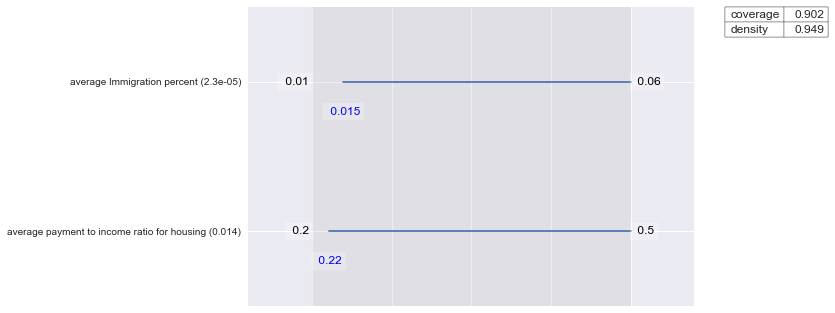

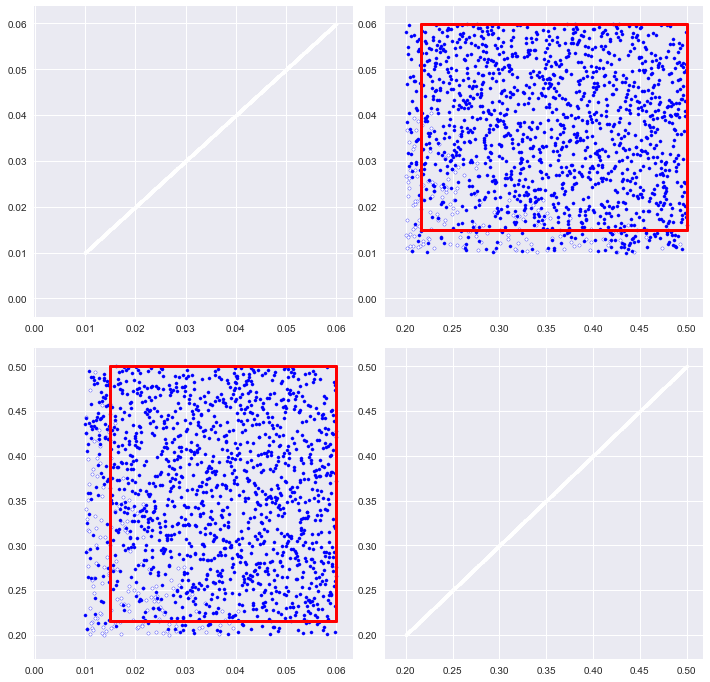

In [12]:
valuebox = 3
box_2.inspect(valuebox)
box_2.select(valuebox)

top_box = valuebox
box_2.inspect(top_box, style='graph')

fig = box_2.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [15]:
def classifyBoth(data):
    ooi_d = 'People with No Settlements'
    result_d = data[ooi_d]
    
    ooi_i = 'Illegal Slum Population'
    result_i = np.max(data[ooi_i], axis=1)
    
    #make an empty array of length equal to number of cases 
    classes = np.zeros(result_d.shape[0])
    
    #combine infectious and deceased checks
    classes[(result_d[:, -1] > 2000000) 
            & (result_i > 20000)] = 1
    
    return classes

combo_prim = prim.setup_prim(results2, classifyBoth,  
                           threshold=0.8, threshold_type=1)
box3 = combo_prim.find_box()

[MainProcess/INFO] 1500 points remaining, containing 1499 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.95, coverage: 0.9506337558372249, density: 1.0 restricted_dimensions: 1


In [16]:
box3.show_tradeoff()
mpld3.display()

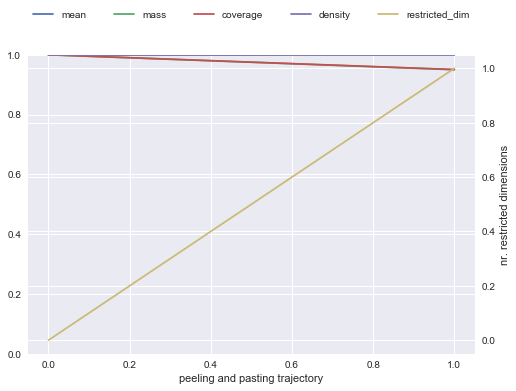

In [17]:
box3.show_ppt()
plt.show()

coverage    0.950634
density            1
mass            0.95
mean               1
res dim            1
Name: 1, dtype: object

                                        box 1                    
                                          min       max qp values
Average Residential approval period  0.500723  1.924913  0.386619



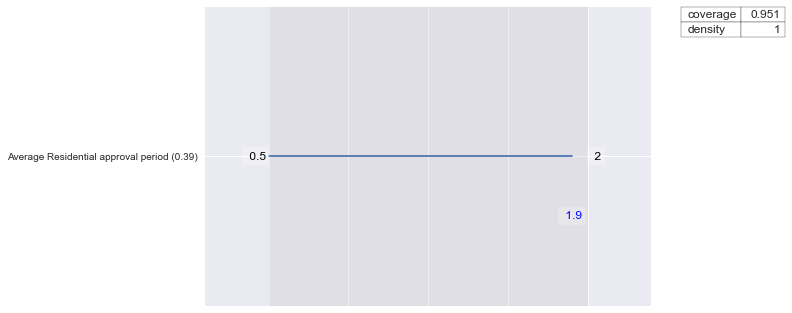

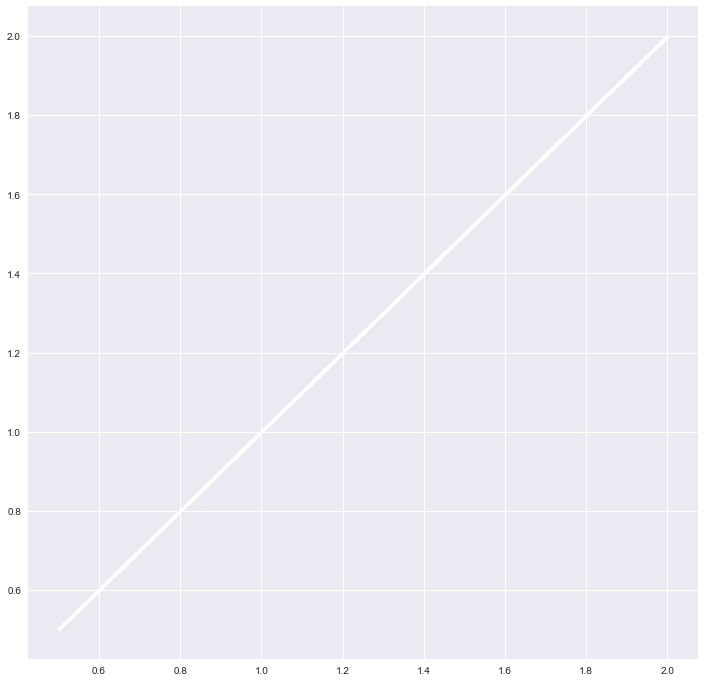

In [18]:
valuebox = 1
box3.inspect(valuebox)
box3.select(valuebox)

top_box = valuebox
box3.inspect(top_box, style='graph')

fig = box3.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [21]:
def classifyUrbanNon(data):
    ooi = 'Urban Non Residential Area'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome<115] = 1
    return classes


prim_obj = prim.setup_prim(results2, classifyUrbanNon, threshold=0.8)
box_4 = prim_obj.find_box()

[MainProcess/INFO] 1500 points remaining, containing 1350 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.566, coverage: 0.6288888888888889, density: 1.0 restricted_dimensions: 5


In [22]:
box_4.show_tradeoff()
mpld3.display()

coverage    0.661481
density     0.998881
mass           0.596
mean        0.998881
res dim            4
Name: 10, dtype: object

                                      box 10                        
                                         min       max     qp values
average Immigration percent         0.025459  0.059989  1.491411e-34
Base Non Economic Reconv rate       0.011884  0.049983  1.041209e-01
Base Slum reconversion rate         0.010012  0.057509  1.065126e-01
Base Economic area Conversion rate  0.010020  0.057281  2.226872e-01



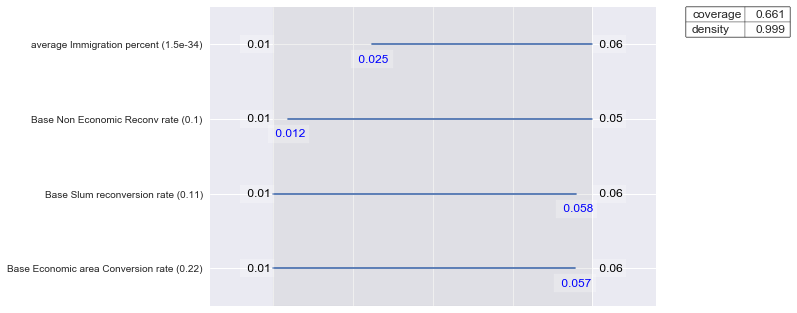

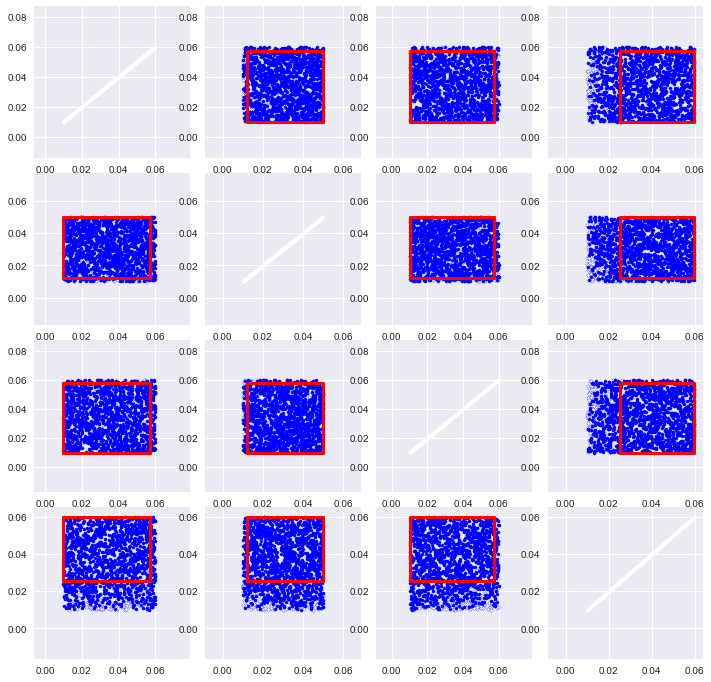

In [23]:
valuebox = 10
box_4.inspect(valuebox)
box_4.select(valuebox)

top_box = valuebox
box_4.inspect(top_box, style='graph')

fig = box_4.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [24]:
def classifyGreenA(data):
    ooi = 'Green Area'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome<6] = 1
    return classes


prim_obj = prim.setup_prim(results2, classifyGreenA, threshold=0.8)
box_5 = prim_obj.find_box()

[MainProcess/INFO] 1500 points remaining, containing 808 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.116, coverage: 0.21534653465346534, density: 1.0 restricted_dimensions: 12


In [25]:
box_5.show_tradeoff()
mpld3.display()

coverage    0.715347
density     0.883792
mass           0.436
mean        0.883792
res dim            4
Name: 16, dtype: object

                                        box 16                        
                                           min       max     qp values
Base Economic area Conversion rate    0.028868  0.059995  4.476737e-45
Base Green Area commisioned per year  0.020005  0.053750  5.714298e-04
average Immigration percent           0.014731  0.059989  1.911079e-03
Base Green Area Reconversion rate     0.003809  0.029995  7.323435e-03



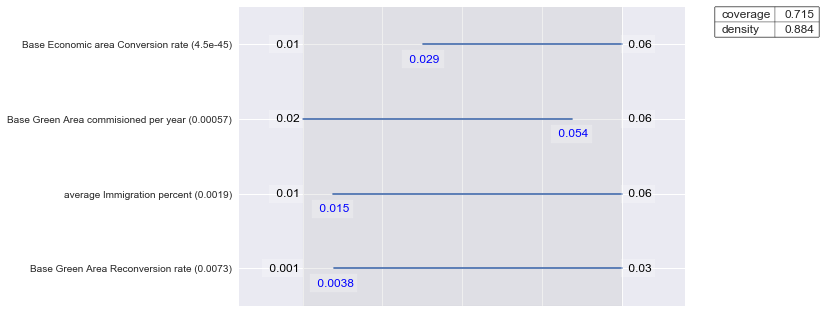

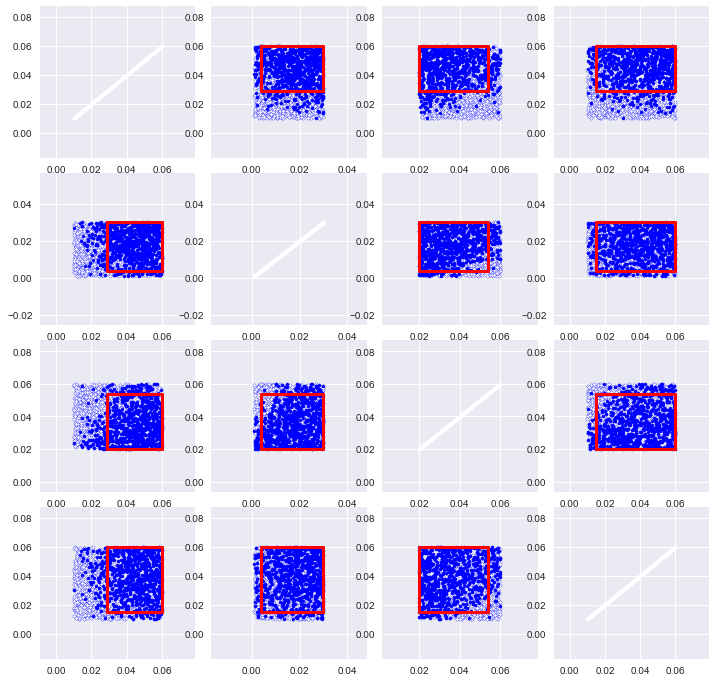

In [26]:
valuebox = 16
box_5.inspect(valuebox)
box_5.select(valuebox)

top_box = valuebox
box_5.inspect(top_box, style='graph')

fig = box_5.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [27]:
def classifySlumA(data):
    ooi = 'Slum Area'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome >12 ] = 1
    return classes


prim_obj = prim.setup_prim(results2, classifySlumA, threshold=0.8)
box_6 = prim_obj.find_box()

[MainProcess/INFO] 1500 points remaining, containing 967 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.596, coverage: 0.9245087900723888, density: 1.0 restricted_dimensions: 1


In [28]:
box_6.show_tradeoff()
mpld3.display()

coverage           1
density     0.678596
mass            0.95
mean        0.678596
res dim            1
Name: 1, dtype: object

                                box 1                    
                                  min       max qp values
Base Slum reconversion rate  0.010012  0.057509   0.00384



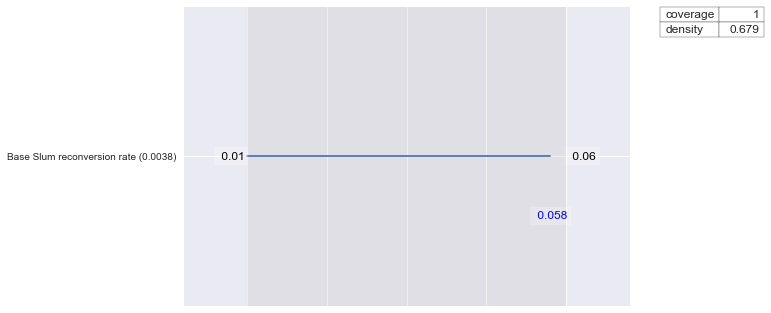

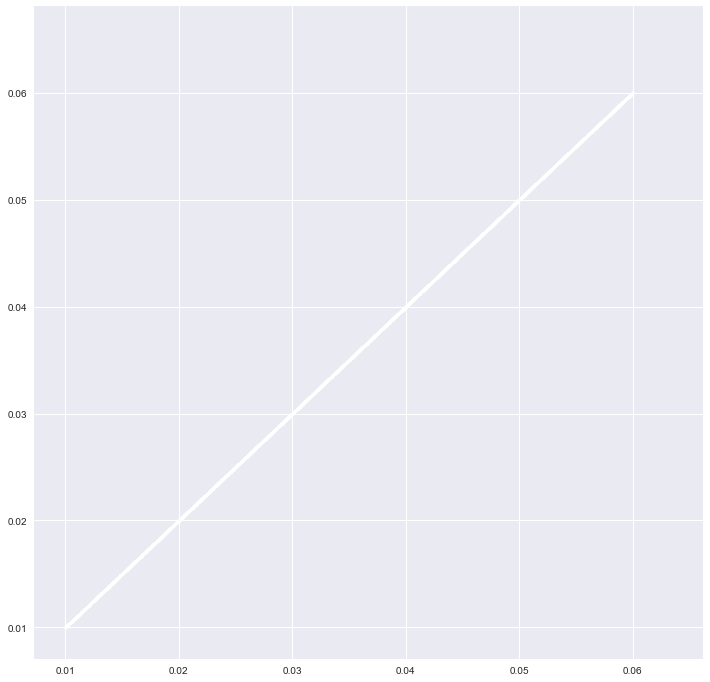

In [29]:
valuebox = 1
box_6.inspect(valuebox)
box_6.select(valuebox)

top_box = valuebox
box_6.inspect(top_box, style='graph')

fig = box_6.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [30]:
def classifySlumPoP(data):
    ooi = 'Illegal Slum Population'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome >20000 ] = 1
    return classes


prim_obj = prim.setup_prim(results2, classifySlumPoP, threshold=0.8)
box_6 = prim_obj.find_box()

[MainProcess/INFO] 1500 points remaining, containing 1136 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.51, coverage: 0.6734154929577465, density: 1.0 restricted_dimensions: 2


In [31]:
box_6.show_tradeoff()
mpld3.display()

coverage    0.708627
density     0.998759
mass        0.537333
mean        0.998759
res dim            2
Name: 12, dtype: object

                                 box 12                        
                                    min       max     qp values
Base Slum reconversion rate    0.010012  0.038305  5.171874e-94
Slum dwelling area per person  0.000004  0.000006  2.224816e-01



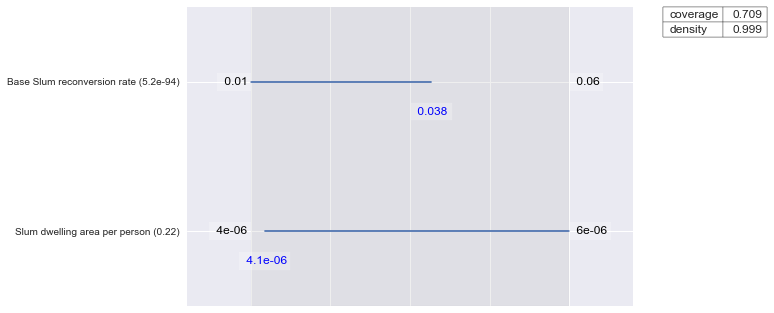

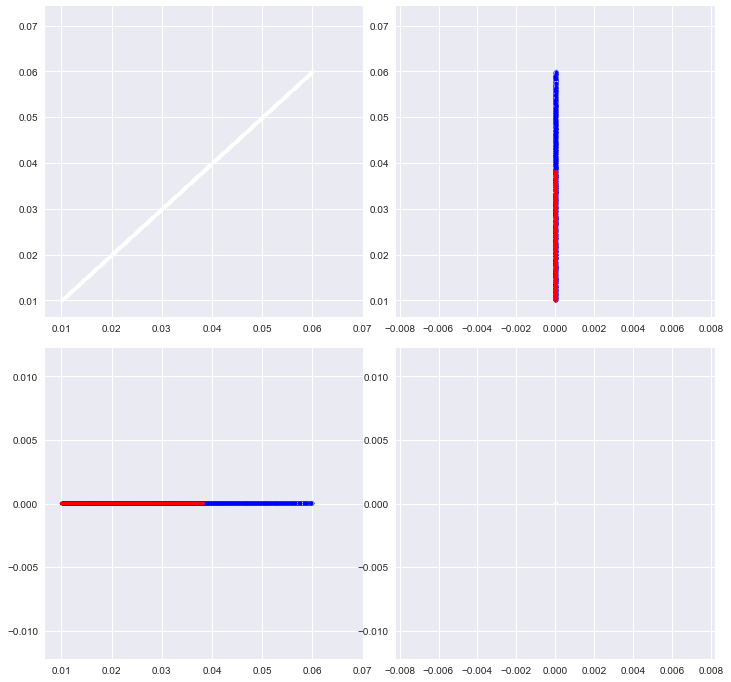

In [32]:
valuebox = 12
box_6.inspect(valuebox)
box_6.select(valuebox)

top_box = valuebox
box_6.inspect(top_box, style='graph')

fig = box_6.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [34]:
def classifyResiA(data):
    ooi = 'Urban Residential Land'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome < 565] = 1
    return classes


prim_obj = prim.setup_prim(results2, classifyResiA, threshold=0.8)
box_5 = prim_obj.find_box()

[MainProcess/INFO] 1500 points remaining, containing 1043 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.24533333333333332, coverage: 0.35282837967401726, density: 1.0 restricted_dimensions: 8


In [35]:
box_5.show_tradeoff()
mpld3.display()

coverage    0.520614
density     0.971377
mass        0.372667
mean        0.971377
res dim            3
Name: 19, dtype: object

                                 box 19                        
                                    min       max     qp values
Base Non Economic Reconv rate  0.010025  0.026507  8.142588e-60
Average Mortality Rate         0.001274  0.001540  1.605529e-01
average Immigration percent    0.010026  0.057812  2.894794e-01



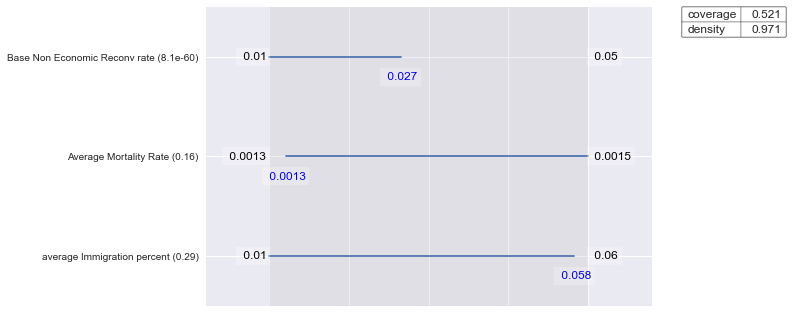

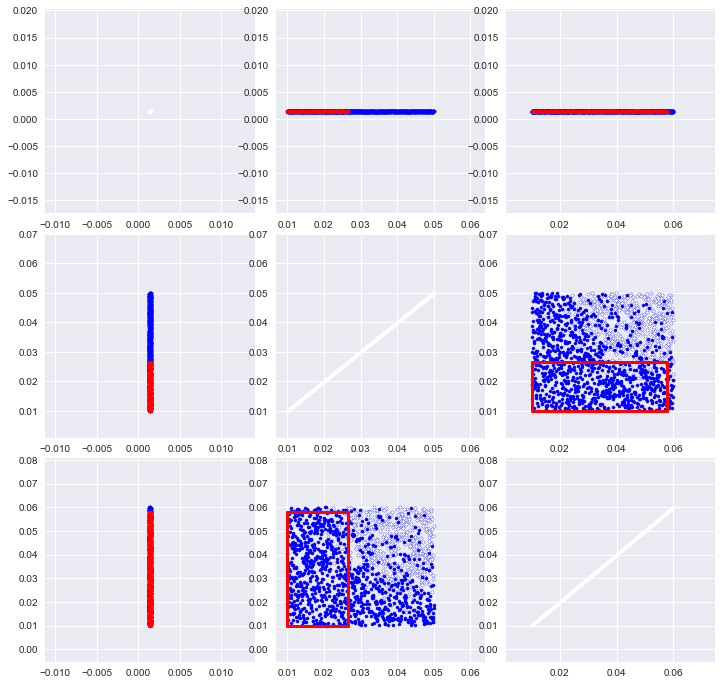

In [36]:
valuebox = 19
box_5.inspect(valuebox)
box_5.select(valuebox)

top_box = valuebox
box_5.inspect(top_box, style='graph')

fig = box_5.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

coverage    0.582317
density     0.998693
mass            0.51
mean        0.998693
res dim            4
Name: 13, dtype: object

                                      box 13                        
                                         min       max     qp values
Base Non Economic Reconv rate       0.010021  0.033840  4.422048e-39
house construction time             0.586194  1.999090  4.944711e-02
average Immigration percent         0.010002  0.058025  1.078866e-01
Base Economic area Conversion rate  0.010026  0.057770  2.225620e-01



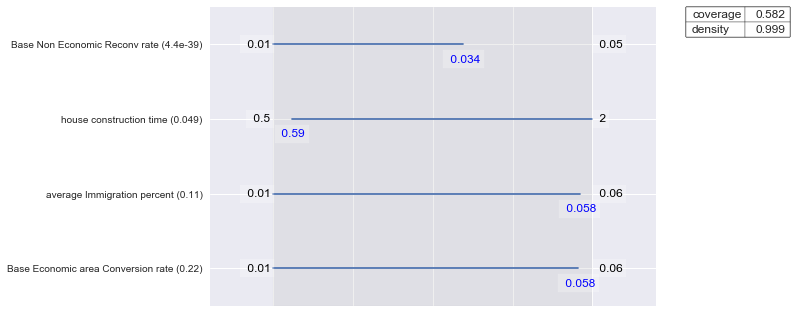

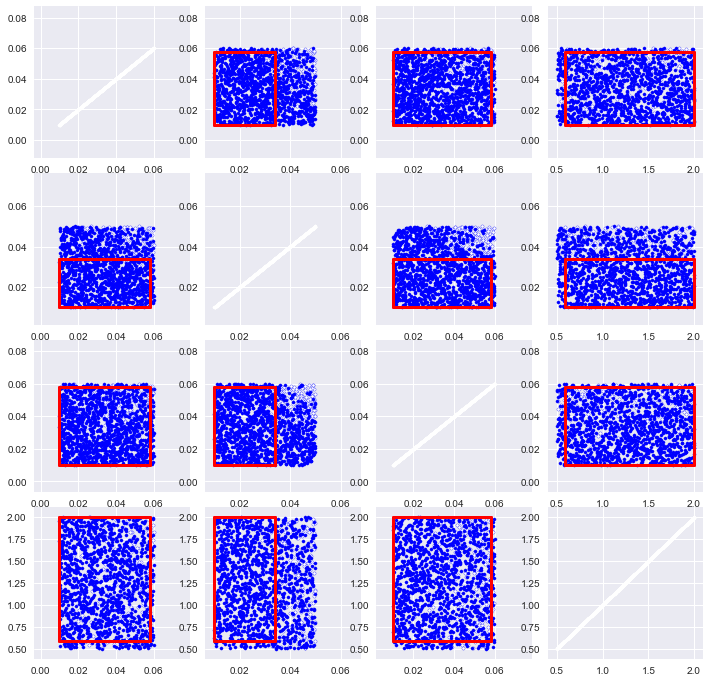

In [53]:
valuebox = 13
box_5.inspect(valuebox)
box_5.select(valuebox)

top_box = valuebox
box_5.inspect(top_box, style='graph')

fig = box_5.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [49]:
def classifyBothAffordResidentialArea(data):
    ooi_d = 'Housing Affordability Rating'
    result_d = data[ooi_d]
    
    ooi_i = 'Urban Residential Land'
    result_i = np.max(data[ooi_i], axis=1)
    
    #make an empty array of length equal to number of cases 
    classes = np.zeros(result_d.shape[0])
    
    #combine infectious and deceased checks
    classes[(result_d[:, -1] > 10) 
            & (result_i <570)] = 1
    
    return classes

combo_prim = prim.setup_prim(results2, classifyBothAffordResidentialArea,  
                           threshold=0.8, threshold_type=1)
box3 = combo_prim.find_box()

[MainProcess/INFO] 1500 points remaining, containing 329 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.06, coverage: 0.2735562310030395, density: 1.0 restricted_dimensions: 14


In [50]:
box3.show_tradeoff()
mpld3.display()

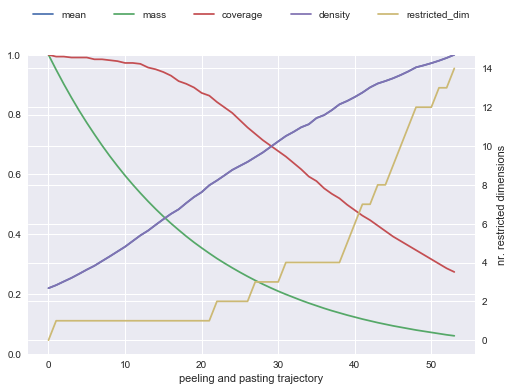

In [51]:
box3.show_ppt()
plt.show()

coverage    0.696049
density     0.691843
mass        0.220667
mean        0.691843
res dim            3
Name: 29, dtype: object

                                               box 29                        
                                                  min       max     qp values
average Immigration percent                  0.010026  0.024185  1.898172e-63
average payment to income ratio for housing  0.256913  0.499965  7.400115e-03
Base Non Economic Reconv rate                0.010025  0.048187  2.680646e-01



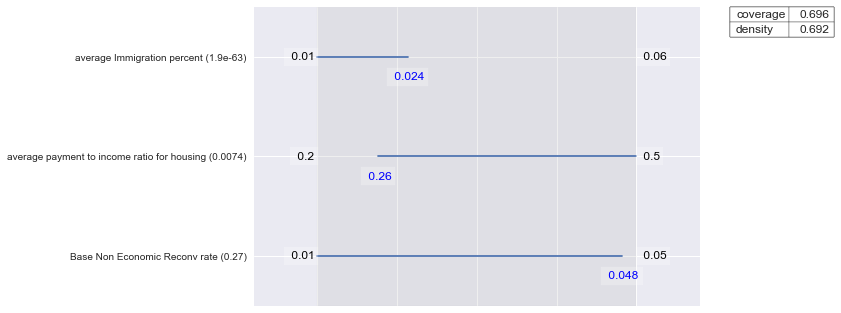

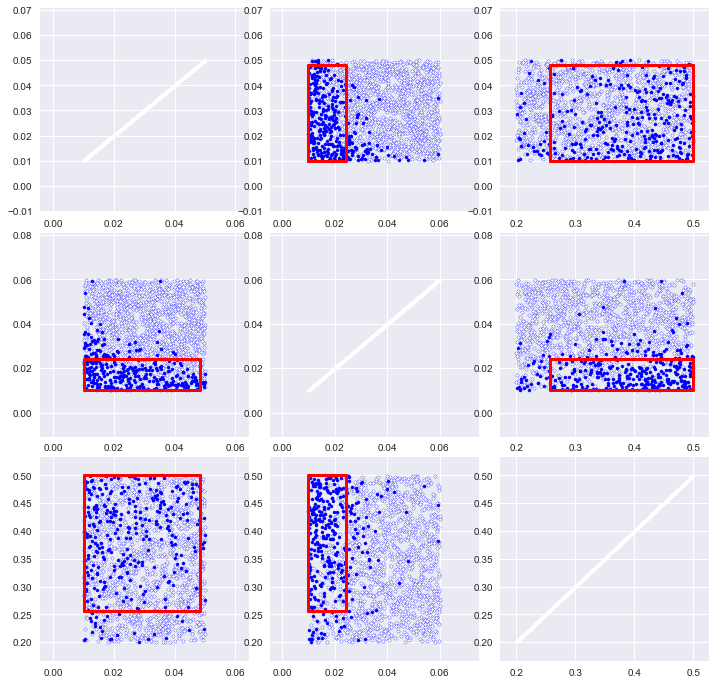

In [52]:
valuebox = 29
box3.inspect(valuebox)
box3.select(valuebox)

top_box = valuebox
box3.inspect(top_box, style='graph')

fig = box3.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [54]:
def classifyBothAffordNonResidentialArea(data):
    ooi_d = 'Housing Affordability Rating'
    result_d = data[ooi_d]
    
    ooi_i = 'Urban Non Residential Area'
    result_i = np.max(data[ooi_i], axis=1)
    
    #make an empty array of length equal to number of cases 
    classes = np.zeros(result_d.shape[0])
    
    #combine infectious and deceased checks
    classes[(result_d[:, -1] > 10) 
            & (result_i <125)] = 1
    
    return classes

combo_prim = prim.setup_prim(results2, classifyBothAffordNonResidentialArea,  
                           threshold=0.8, threshold_type=1)
box3 = combo_prim.find_box()

[MainProcess/INFO] 1500 points remaining, containing 1054 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.23266666666666666, coverage: 0.33111954459203036, density: 1.0 restricted_dimensions: 6


In [55]:
box3.show_tradeoff()
mpld3.display()

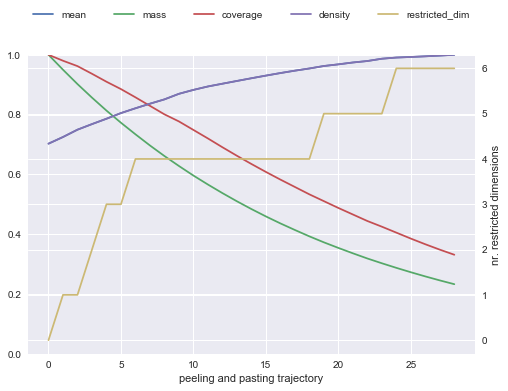

In [56]:
box3.show_ppt()
plt.show()

coverage    0.748577
density      0.88255
mass           0.596
mean         0.88255
res dim            4
Name: 10, dtype: object

                                       box 10                        
                                          min       max     qp values
average Immigration percent          0.019163  0.059989  5.452725e-12
Average Residential approval period  0.779933  1.999789  3.708641e-09
Base Slum reconversion rate          0.010012  0.057509  2.470864e-02
Base Economic area Conversion rate   0.010020  0.057435  9.211412e-02



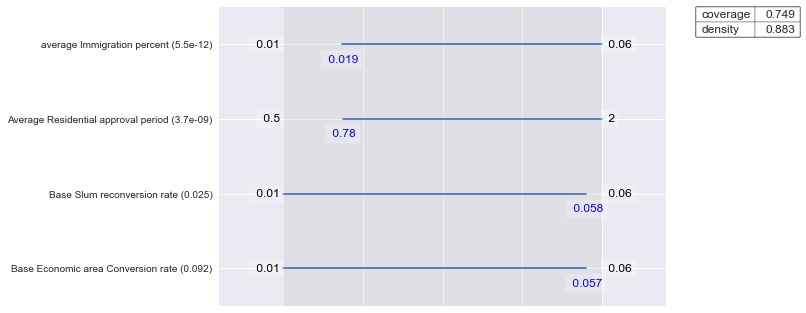

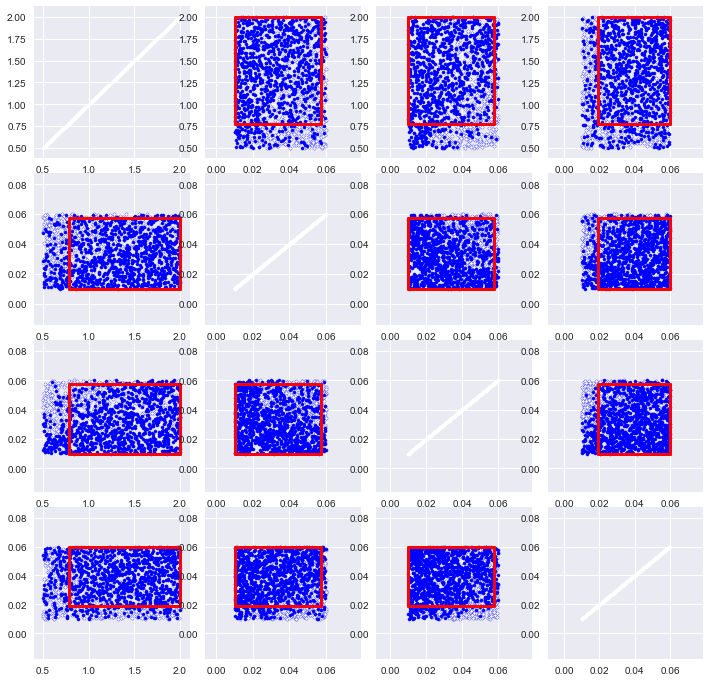

In [58]:
valuebox = 10
box3.inspect(valuebox)
box3.select(valuebox)

top_box = valuebox
box3.inspect(top_box, style='graph')

fig = box3.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [60]:
def classifyBothAffordSettlements(data):
    ooi_d = 'Housing Affordability Rating'
    result_d = data[ooi_d]
    
    ooi_i = 'People with No Settlements'
    result_i = np.max(data[ooi_i], axis=1)
    
    #make an empty array of length equal to number of cases 
    classes = np.zeros(result_d.shape[0])
    
    #combine infectious and deceased checks
    classes[(result_d[:, -1] > 10) 
            & (result_i >5000000)] = 1
    
    return classes

combo_prim = prim.setup_prim(results2, classifyBothAffordSettlements,  
                           threshold=0.8, threshold_type=1)
box3 = combo_prim.find_box()

[MainProcess/INFO] 1500 points remaining, containing 1438 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.628, coverage: 0.655076495132128, density: 1.0 restricted_dimensions: 4


In [61]:
box3.show_tradeoff()
mpld3.display()

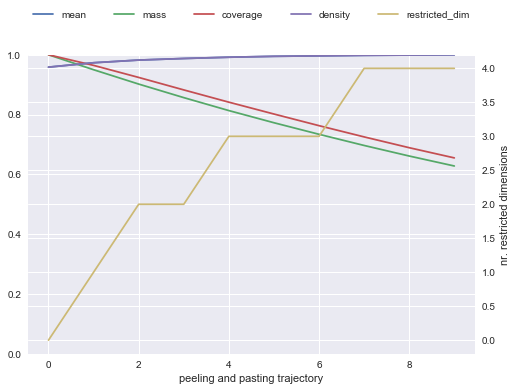

In [62]:
box3.show_ppt()
plt.show()

coverage    0.762865
density     0.996367
mass           0.734
mean        0.996367
res dim            3
Name: 6, dtype: object

                                                box 6                        
                                                  min       max     qp values
average Immigration percent                  0.019505  0.059989  4.873674e-09
average payment to income ratio for housing  0.216000  0.499965  2.149803e-02
average Emmigration percent                  0.009961  0.049995  1.218253e-01



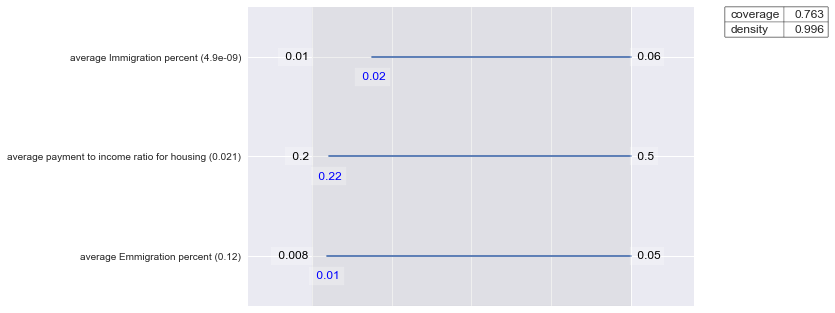

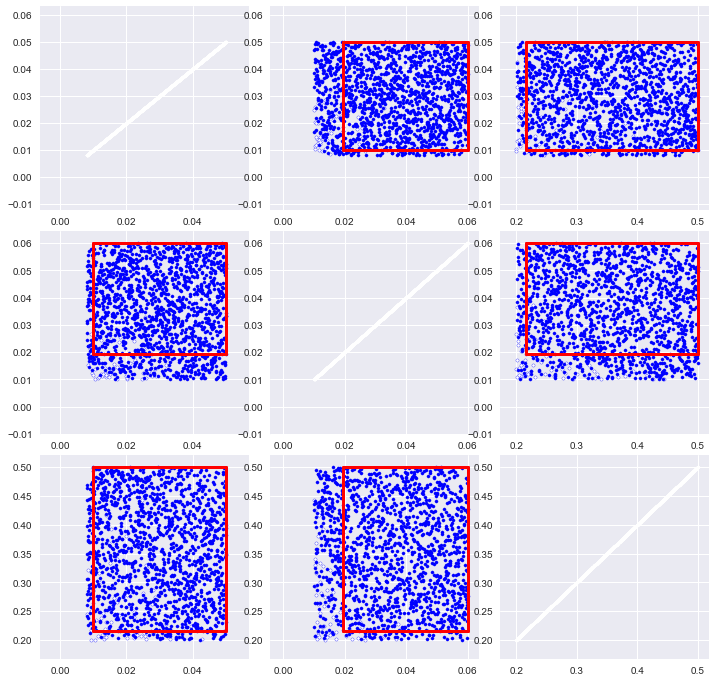

In [63]:
valuebox = 6
box3.inspect(valuebox)
box3.select(valuebox)

top_box = valuebox
box3.inspect(top_box, style='graph')

fig = box3.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()